<a href="https://colab.research.google.com/github/chasubeen/ESAA_8th_YB/blob/Week_11/%ED%8C%8C%EB%A8%B8%EC%99%84%205%EC%9E%A5_%EB%B3%B4%EC%8A%A4%ED%84%B4%20%EC%A3%BC%ED%83%9D%20%EA%B0%80%EA%B2%A9%20%EC%98%88%EC%B8%A1(%EC%8B%A4%EC%8A%B5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **📌 Data Description**
- CRIM: 지역별 범죄 발생률
- ZN: 25,000평방피트를 초과하는 거주 지역의 비율
- NDUS: 비상업 지역 넓이 비율
- CHAS: 찰스강에 대한 더미 변수  
(강의 경계에 위치한 경우는 1, 아니면 0)
- NOX: 일산화질소 농도
- RM: 거주할 수 있는 방 개수
- AGE: 1940년 이전에 건축된 소유 주택의 비율
- DIS: 5개 주요 고용센터까지의 가중 거리
- RAD: 고속도로 접근 용이도
- TAX: 10,000달러당 재산세율
- PTRATIO: 지역의 교사와 학생 수 비율
- B: 지역의 흑인 거주 비율
- LSTAT: 하위 계층의 비율
- MEDV: 본인 소유의 주택 가격(중앙값)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

%matplotlib inline

- sklearn version에 따른 boston 데이터 load 이슈로 인해 원본 데이터를 불러와 데이터를 직접 가공함

In [6]:
# boston 데이터 셋 로드

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows = 22, header = None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

feature_names = ['CRIM', 'ZN', 'INDUS','CHAS','NOX', 'RM', 
                    'AGE', 'DIS', 'RAD','TAX', 'PTRATIO', 'B', 'LSTAT']

# boston 데이타셋 DataFrame 변환 
bostonDF = pd.DataFrame(data, columns = feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함
bostonDF['PRICE'] = target
print('Boston 데이타셋 크기 :',bostonDF.shape)

bostonDF.head()

Boston 데이타셋 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [7]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


- 데이터 세트 피처의 Null 값은 없음
- 모두 float형


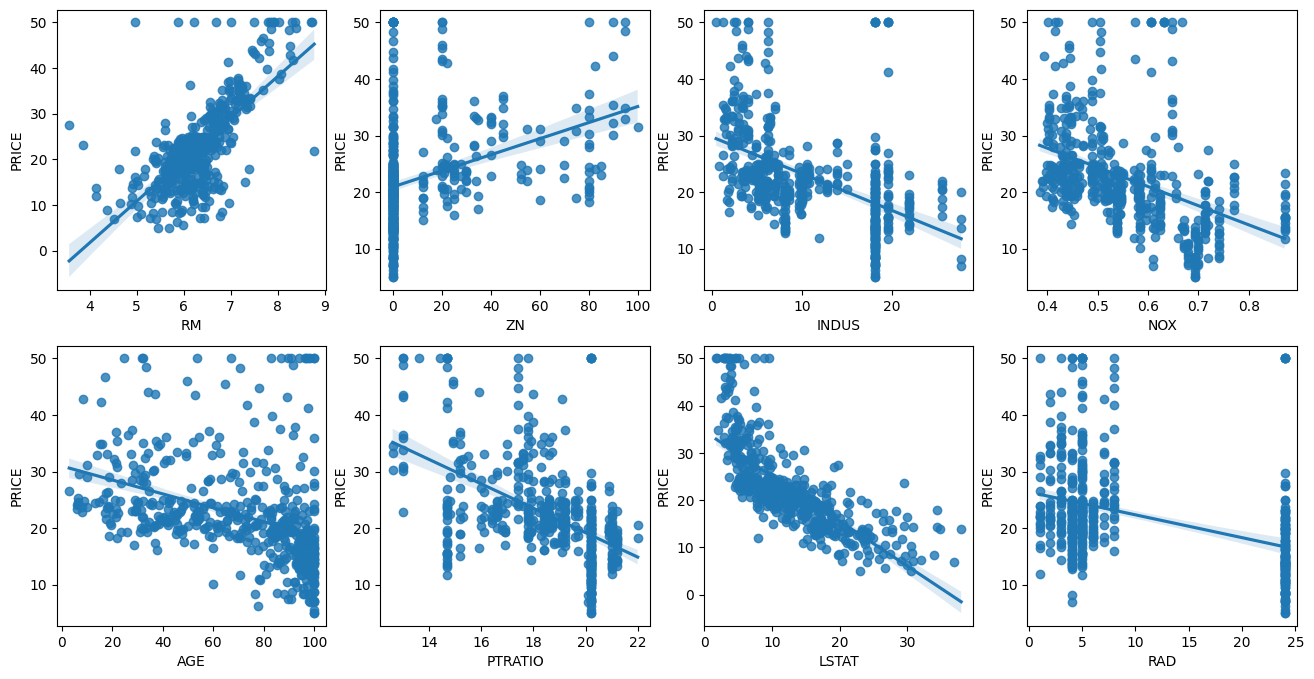

In [9]:
### 각 컬럼별로 주택가격에 미치는 영향도를 조사

# 2개의 행과 4개의 열을 가진 subplots를 이용
# axs는 4x2개의 ax를 가짐
fig, axs = plt.subplots(figsize = (16,8), ncols = 4 , nrows = 2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']

for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4

    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x = feature, y = 'PRICE',data = bostonDF, ax = axs[row][col])

- 다른 칼럼보다 ```RM```과 ```LSTAT```의 ```PRICE``` 영향도가 가장 두드러지게 나타남

In [10]:
### 회귀 모델 생성
# 학습과 테스트 데이터 세트로 분리하고 학습/예측/평가 수행

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis = 1,inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, 
                                                    test_size = 0.3, random_state = 156)

# Linear Regression OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)

mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297 , RMSE : 4.159
Variance score : 0.757


In [11]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164826
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [12]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성
# index가 컬럼명임에 유의

coeff = pd.Series(data = np.round(lr.coef_, 1), index = X_data.columns)
coeff.sort_values(ascending = False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

- ```RM```이 양의 값으로 회귀 계수가 가장 크다.
- ```NOX``` 피처의 회귀 계수의 (-) 값이 너무 커 보임

In [13]:
### 교차 검증

from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)
lr = LinearRegression()

# cross_val_score( )로 5 Fold 셋으로 MSE 를 구한 뒤 이를 기반으로 다시 RMSE를 구함 
neg_mse_scores = cross_val_score(lr, X_data, y_target, 
                                 scoring = "neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores) # 원래의 평가 지표로 변환
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수 
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 


- 평균 RMSE는 약 5.829